In [1]:
# Load all necessary libraries

# Data Processing
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree, export_graphviz
from IPython.display import Image

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Model Evaluation & Selection
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    learning_curve,
    KFold
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    r2_score
)

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Hyperparameter Tuning
from scipy.stats import randint, uniform

# Utility
import joblib
import calendar


<h1>Part 1: Data explore and feature engineering </h1>

In [2]:
import pandasql as psql

# Load CSV files into DataFrames
labour_data_df = pd.read_csv('Resources/labour_stats_by_sex_2014onwards.csv')
household_spending_df = pd.read_csv('Resources/householdspending_2014onwards.csv')
total_travelloans_df = pd.read_csv('Resources/travelloans_2014onwards.csv')

# Define the SQL query and merge dataframes, ensuring only one 'Time Period' column is selected
query = """
SELECT
    l."Time Period" AS "Time Period",  -- Keep 'Time Period' from one table
    l.*,
    h.*,
    t.*
FROM labour_data_df l
JOIN household_spending_df h ON l."Time Period" = h."Time Period"
JOIN total_travelloans_df t ON l."Time Period" = t."Time Period"
"""

# Execute the query and get the result, passing DataFrames explicitly as locals
full_data_df = psql.sqldf(query, locals())

# Drop duplicate 'Time Period' columns
full_data_df = full_data_df.loc[:, ~full_data_df.columns.duplicated()]

# Drop missing values (simulating cleaning)
full_data_df = full_data_df.dropna()

# Show the final integrated data
print(full_data_df.head())


  Time Period Employed Males (Full Time)  ETP Males  \
0    Jan 2014                    5,111.3       66.2   
1    Feb 2014                    5,178.9       66.9   
2    Mar 2014                    5,126.5       67.0   
3    Apr 2014                    5,153.5       67.0   
4    May 2014                    5,155.4       66.8   

  Employed Females (Full Time)  ETP Females     Food Clothing and footwear  \
0                      2,817.4         54.1    7,337               2,597.4   
1                      2,881.4         54.7  6,640.9               2,091.1   
2                      2,836.3         55.2  7,265.5               2,401.2   
3                      2,824.4         55.2    7,010               2,513.2   
4                      2,867.4         55.3  7,050.9               2,621.5   

   Total Value of Loans  
0                  57.9  
1                  61.5  
2                  62.3  
3                  60.6  
4                  75.2  


In [3]:
full_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Time Period                   129 non-null    object 
 1   Employed Males (Full Time)    129 non-null    object 
 2   ETP Males                     129 non-null    float64
 3   Employed Females (Full Time)  129 non-null    object 
 4   ETP Females                   129 non-null    float64
 5   Food                          129 non-null    object 
 6   Clothing and footwear         129 non-null    object 
 7   Total Value of Loans          129 non-null    float64
dtypes: float64(3), object(5)
memory usage: 9.1+ KB


In [4]:
#data clean

# Split the 'Time Period' column into 'Month' and 'Year' columns and drop 'Time Period'
full_data_df[['Month','Year']] = full_data_df['Time Period'].str.split(' ',expand=True)
full_data_df = full_data_df.drop('Time Period',axis=1)

#Convert month abbreviations (e.g., 'Jan', 'Feb') to numerical values (1-12)
full_data_df['Month'] = full_data_df['Month'].apply(lambda x: list(calendar.month_abbr).index(x))
#covert 'year' from object to int
full_data_df['Year'] = full_data_df['Year'].astype(int)


In [5]:
# Convert population-related columns from strings with commas to floats
cols_to_clean = ['Employed Males (Full Time)', 'Employed Females (Full Time)', 'Food', 'Clothing and footwear']

for col in cols_to_clean:
    full_data_df[col] = full_data_df[col].str.replace(',', '').astype(float)

# Multiply only population-related columns by 1000 (to return to full numbers)
full_data_df[['Employed Males (Full Time)', 'Employed Females (Full Time)']] *= 1000


In [6]:
full_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employed Males (Full Time)    129 non-null    float64
 1   ETP Males                     129 non-null    float64
 2   Employed Females (Full Time)  129 non-null    float64
 3   ETP Females                   129 non-null    float64
 4   Food                          129 non-null    float64
 5   Clothing and footwear         129 non-null    float64
 6   Total Value of Loans          129 non-null    float64
 7   Month                         129 non-null    int64  
 8   Year                          129 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 10.1 KB


In [7]:
#copy the cleaned data
cleaned_df = full_data_df.copy()
cleaned_df.head(10)

,Employed Males (Full Time),ETP Males,Employed Females (Full Time),ETP Females,Food,Clothing and footwear,Total Value of Loans,Month,Year
0,5111300.0,66.2,2817400.0,54.1,7337.0,2597.4,57.9,1,2014
1,5178900.0,66.9,2881400.0,54.7,6640.9,2091.1,61.5,2,2014
2,5126500.0,67.0,2836300.0,55.2,7265.5,2401.2,62.3,3,2014
3,5153500.0,67.0,2824400.0,55.2,7010.0,2513.2,60.6,4,2014
4,5155400.0,66.8,2867400.0,55.3,7050.9,2621.5,75.2,5,2014
5,5121400.0,66.7,2855300.0,55.3,6784.6,2533.2,60.2,6,2014
6,5172600.0,66.6,2871000.0,55.1,7127.1,2515.1,59.2,7,2014
7,5120600.0,66.5,2843600.0,55.3,7285.7,2352.0,53.4,8,2014
8,5131000.0,66.3,2847400.0,55.0,7034.2,2486.1,50.8,9,2014
9,5134200.0,66.4,2847500.0,54.9,7491.9,2649.8,60.6,10,2014


In [8]:
# Display the summary statistics of the cleaned DataFrame
print(cleaned_df.describe())

       Employed Males (Full Time)   ETP Males  Employed Females (Full Time)  \
count                1.290000e+02  129.000000                  1.290000e+02   
mean                 5.475324e+06   66.910078                  3.280787e+06   
std                  2.756153e+05    1.021476                  3.429499e+05   
min                  5.111300e+06   62.900000                  2.817400e+06   
25%                  5.239000e+06   66.500000                  2.982100e+06   
50%                  5.431600e+06   66.900000                  3.216000e+06   
75%                  5.669800e+06   67.600000                  3.546900e+06   
max                  6.042200e+06   68.800000                  3.955400e+06   

       ETP Females          Food  Clothing and footwear  Total Value of Loans  \
count   129.000000    129.000000             129.000000            129.000000   
mean     57.465891   8905.607752            3249.077519             43.589922   
std       1.972724   1436.630075             

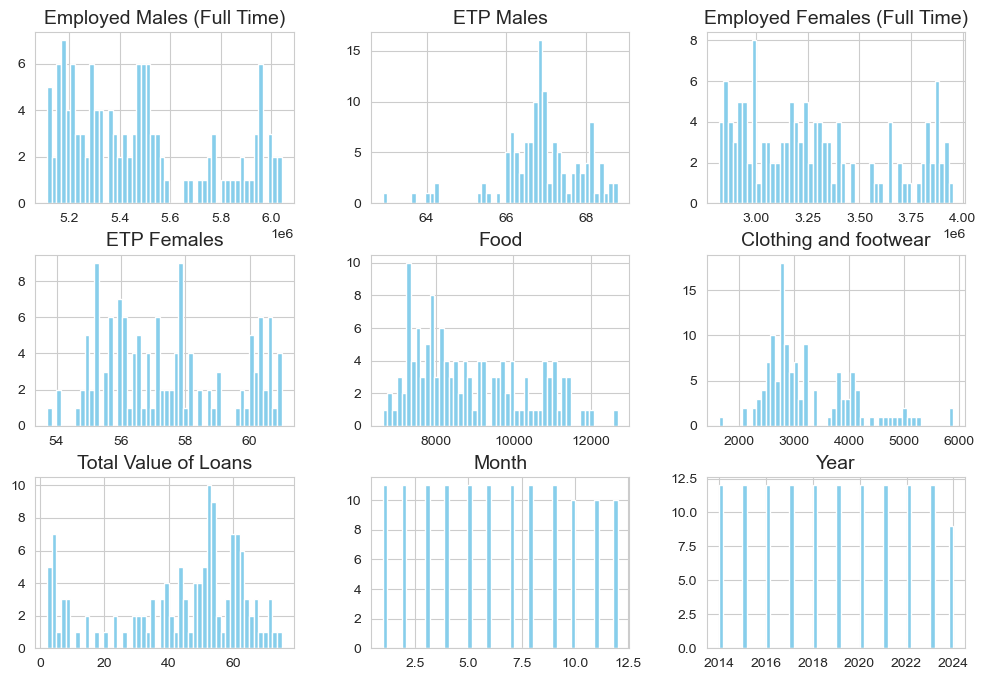

In [9]:
# Plot a histogram of all numerical data columns in the cleaned DataFrame
# Create the 'plots' directory if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

# Define the default font sizes for the plot
plt.rc('font', size=14)  # Set the default font size
plt.rc('axes', labelsize=14, titlesize=14)  # Set font size for axis labels and title
plt.rc('legend', fontsize=14)  # Set font size for the legend
plt.rc('xtick', labelsize=10)  # Set font size for x-axis tick labels
plt.rc('ytick', labelsize=10)  # Set font size for y-axis tick labels

# Plot a histogram of all numerical data columns in the cleaned DataFrame
cleaned_df.hist(bins=50, figsize=(12, 8), color="skyblue")  # Adjust bins, figure size, and color


# Save the histogram plot to the 'plots' directory with high resolution (300 dpi)
plt.savefig(os.path.join('./plots', 'Fig1_data_histogram.png'), dpi=300)

# Display the plot
plt.show()  # Display the plot


In [10]:
# remove the highly extreme outliers as we only have 128 entries

def identify_extreme_outliers(data, multiplier=3):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    outliers = np.where((data < lower_bound) | (data > upper_bound))
    return outliers[0]

# Apply to each feature
extreme_outliers = {}
for feature in cleaned_df.columns:
    outliers = identify_extreme_outliers(cleaned_df[feature])
    if len(outliers) > 0:
        extreme_outliers[feature] = outliers

# Print results
for feature, outliers in extreme_outliers.items():
    print(f"Extreme outliers in {feature}: {outliers}")

# Create a mask for rows to keep
rows_to_keep = np.ones(len(cleaned_df), dtype=bool)
for outliers in extreme_outliers.values():
    rows_to_keep[outliers] = False

# Apply the mask to get the cleaned dataframe
df_cleaned = cleaned_df[rows_to_keep]

print(f"Original dataset size: {len(cleaned_df)}")
print(f"Cleaned dataset size: {len(df_cleaned)}")
print(f"Number of rows removed: {len(cleaned_df) - len(df_cleaned)}")



Extreme outliers in ETP Males: [76]
Original dataset size: 129
Cleaned dataset size: 128
Number of rows removed: 1


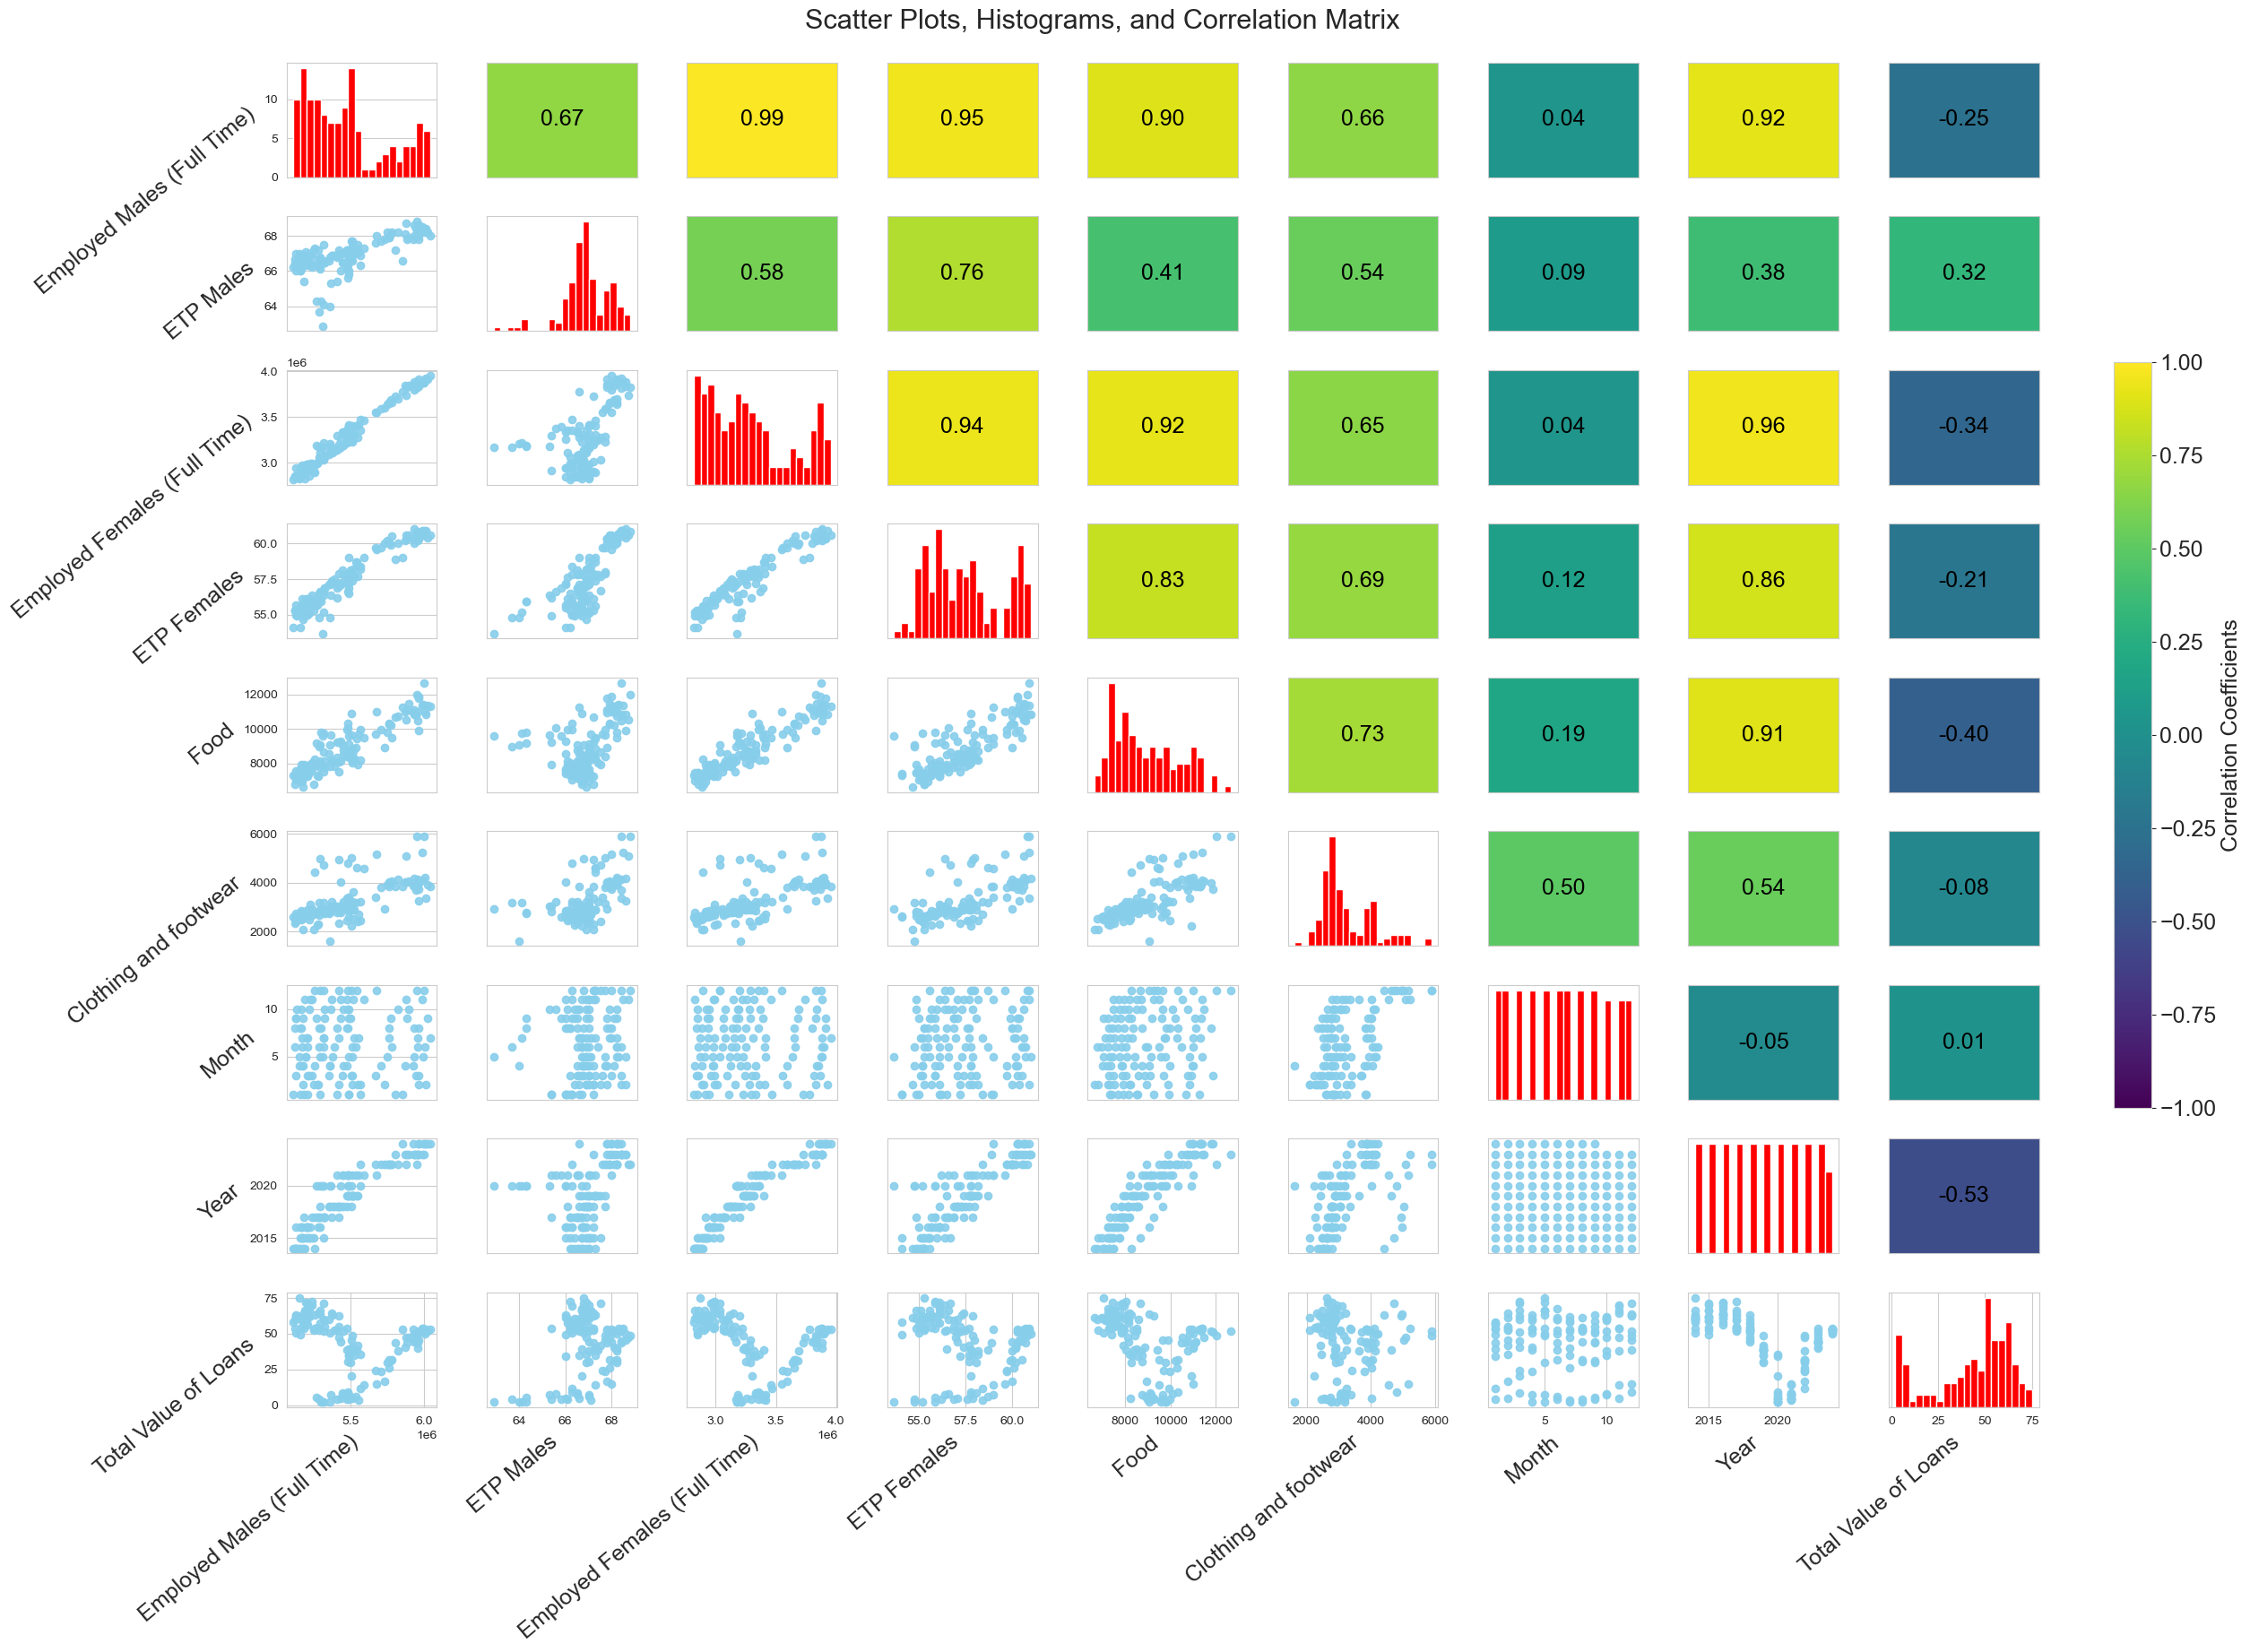

In [11]:
# create correlation matrix
# Reorder columns to put 'Total Value of Loans' last
cols = list(cleaned_df.columns)
cols.remove('Total Value of Loans')
cols.append('Total Value of Loans')
cleaned_df = cleaned_df[cols]

# Compute correlation matrix
corr = cleaned_df.corr()

# Set up color maps
scatter_cmap = 'skyblue'  # Use a consistent red color for the scatter plots
corr_cmap = plt.cm.viridis    # Use viridis for the correlation matrix

# Function to get background color based on correlation value
def get_bg_color(value):
    return corr_cmap(0.5 * (value + 1))

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(cleaned_df.columns), ncols=len(cleaned_df.columns), figsize=(26, 20))

# Fill in the plots
for i in range(len(cleaned_df.columns)):
    for j in range(len(cleaned_df.columns)):
        if i > j:
            # Lower triangle: scatter plots with consistent red color
            axes[i, j].scatter(cleaned_df.iloc[:, j], cleaned_df.iloc[:, i], c=scatter_cmap, alpha=0.9)
        elif i < j:
            # Upper triangle: correlation numbers with colored background
            corr_value = corr.iloc[i, j]
            bg_color = get_bg_color(corr_value)
            axes[i, j].set_facecolor(bg_color)
            axes[i, j].text(0.5, 0.5, f"{corr_value:.2f}",
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=axes[i, j].transAxes,
                            fontsize=18, color='black')
        else:
            # Diagonal: histograms
            axes[i, j].hist(cleaned_df.iloc[:, i], bins=20, color="red")

        # Remove ticks for all plots except leftmost column and bottom row
        if i < len(cleaned_df.columns) - 1:
            axes[i, j].set_xticks([])
        if j > 0:
            axes[i, j].set_yticks([])

# Set column names as labels
for ax, col in zip(axes[-1], cleaned_df.columns):
    ax.set_xlabel(col, rotation=40, ha='right', fontsize=18)
for ax, row in zip(axes[:,0], cleaned_df.columns):
    ax.set_ylabel(row, rotation=40, ha='right', fontsize=18)

# Adjust layout and add title
plt.tight_layout()
plt.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2)
fig.suptitle('Scatter Plots, Histograms, and Correlation Matrix', fontsize=22, y=0.98)

# Add colorbar for correlation matrix
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=corr_cmap, norm=plt.Normalize(vmin=-1, vmax=1)), ax=axes,
                    orientation='vertical', fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Correlation Coefficients', fontsize=18)


# Save the plot to the 'plots' directory with high resolution (300 dpi)
plt.savefig(os.path.join('./plots', 'Fig2_correlation_matrix.png'), dpi=300)  # Save the plot

# Show the plot
plt.show()


In [12]:
#drop some features from the correlation matrix
cleaned_df_drop_features = cleaned_df.drop(['Month','Year', 'Employed Males (Full Time)'],axis=1)

<h1>Part 2: Model Training</h1>

In [13]:
# split data into features and target. this code assumes total travel loans is what is being predicted.
X = cleaned_df_drop_features.drop('Total Value of Loans', axis=1)
y = cleaned_df_drop_features['Total Value of Loans']

X.head()

,ETP Males,Employed Females (Full Time),ETP Females,Food,Clothing and footwear
0,66.2,2817400.0,54.1,7337.0,2597.4
1,66.9,2881400.0,54.7,6640.9,2091.1
2,67.0,2836300.0,55.2,7265.5,2401.2
3,67.0,2824400.0,55.2,7010.0,2513.2
4,66.8,2867400.0,55.3,7050.9,2621.5


In [14]:
# splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=78)

In [15]:
#data standardization before prior to modelling

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Convert the scaled data to a DataFrame and get the summary statistics
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4
count,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01
mean,3.534210e-15,1.492633e-16,-5.563451e-15,1.850372e-16,-3.065449e-16
std,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00
min,-3.666450e+00,-1.390714e+00,-1.888914e+00,-1.577019e+00,-1.461573e+00
25%,-3.921121e-01,-8.848319e-01,-7.557282e-01,-8.664965e-01,-6.546268e-01
50%,-2.829675e-02,-2.468581e-01,-2.317819e-01,-1.828867e-01,-3.704210e-01
75%,7.902877e-01,9.705618e-01,1.169470e+00,8.210916e-01,7.583931e-01
max,1.699826e+00,1.807586e+00,1.669046e+00,2.402198e+00,3.188556e+00


<h2>Part 2.1 : Modelling with random forest</h2>

In [16]:
# training Random forest with hyperparameters

#Hyperparameter Tuning for RandomForestRegressor using RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(100, 2000),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Instantiate RandomizedSearchCV for RandomForestRegressor
random_search_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                      param_distributions=param_dist_rf,
                                      n_iter=100, cv=10, scoring='r2', random_state=42)
random_search_rf.fit(X_train_scaled, y_train)

# Best RandomForestRegressor model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# You can now use `best_rf` for further predictions and evaluations.

# Step 5: Make predictions on the test set
y_pred_rf = best_rf.predict(X_test_scaled)

# Step 6: Evaluate model performance using R² Score
r2 = r2_score(y_test, y_pred_rf)

# Print best hyperparameters and evaluation results
print(f'Best Hyperparameters for best_rf: {random_search_rf.best_params_}')
print(f'Best R² Score from Cross-Validation: {random_search_rf.best_score_:.4f}')
print(f'R² Score on Test Data: {r2:.4f}')

Best Hyperparameters for best_rf: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1942}
Best R² Score from Cross-Validation: 0.8382
R² Score on Test Data: 0.7634


                        Feature  Importance
1  Employed Females (Full Time)    0.316534
0                     ETP Males    0.303912
3                          Food    0.186667
2                   ETP Females    0.110227
4         Clothing and footwear    0.082660


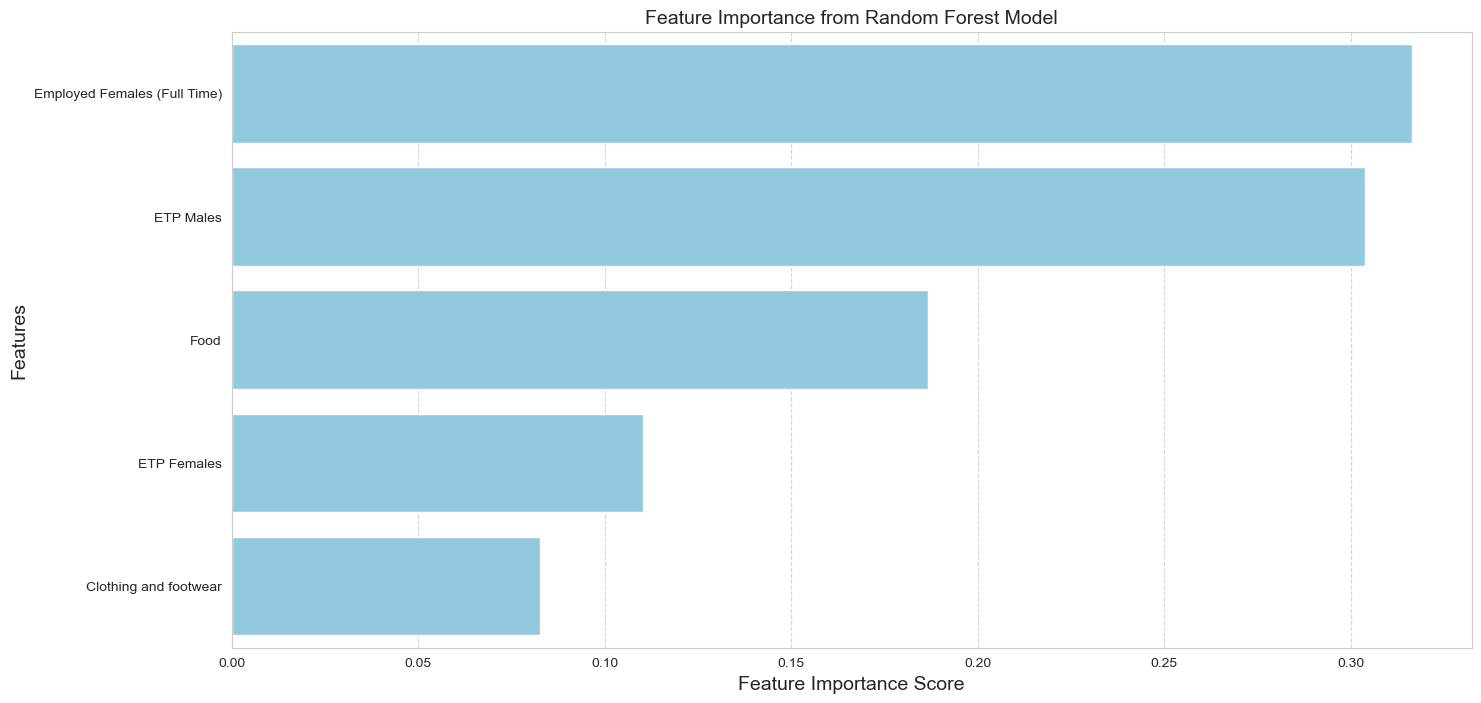

In [17]:
# Plot feature importance

# Feature importance data
feature_importances = best_rf.feature_importances_  # Extract feature importances from the trained model
features = X_train.columns  # Feature names

# Convert to DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance (smallest to largest for better visualization)
importance_df = importance_df.sort_values(by="Importance", ascending = False)

# Display features importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(16, 8))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest Model")
plt.grid(axis="x", linestyle="--", alpha=0.8)  # Add grid for better readability

# Save the plot to the 'plots' directory with high resolution (300 dpi)
plt.savefig(os.path.join('./plots', 'Fig3_feature importance.png'), dpi=300)  # Save the plot

plt.show()


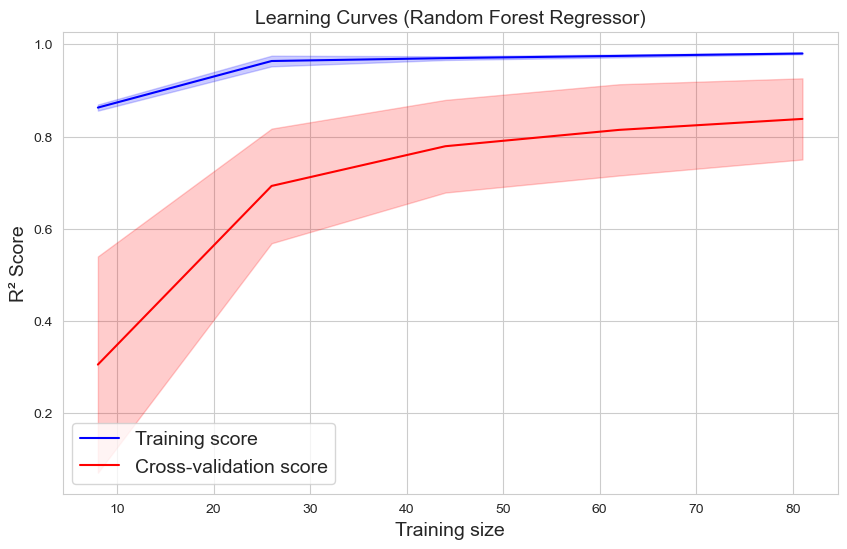

In [18]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(best_rf, X_train_scaled, y_train, cv=10, scoring="r2")

# Calculate the mean and std of the scores
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="red")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
plt.title("Learning Curves (Random Forest Regressor)")
plt.xlabel("Training size")
plt.ylabel("R² Score")
plt.legend()

# Save the plot to the 'plots' directory with high resolution (300 dpi)
plt.savefig(os.path.join('./plots', 'Fig4_Learning Curve.png'), dpi=300)  # Save the plot
plt.show()



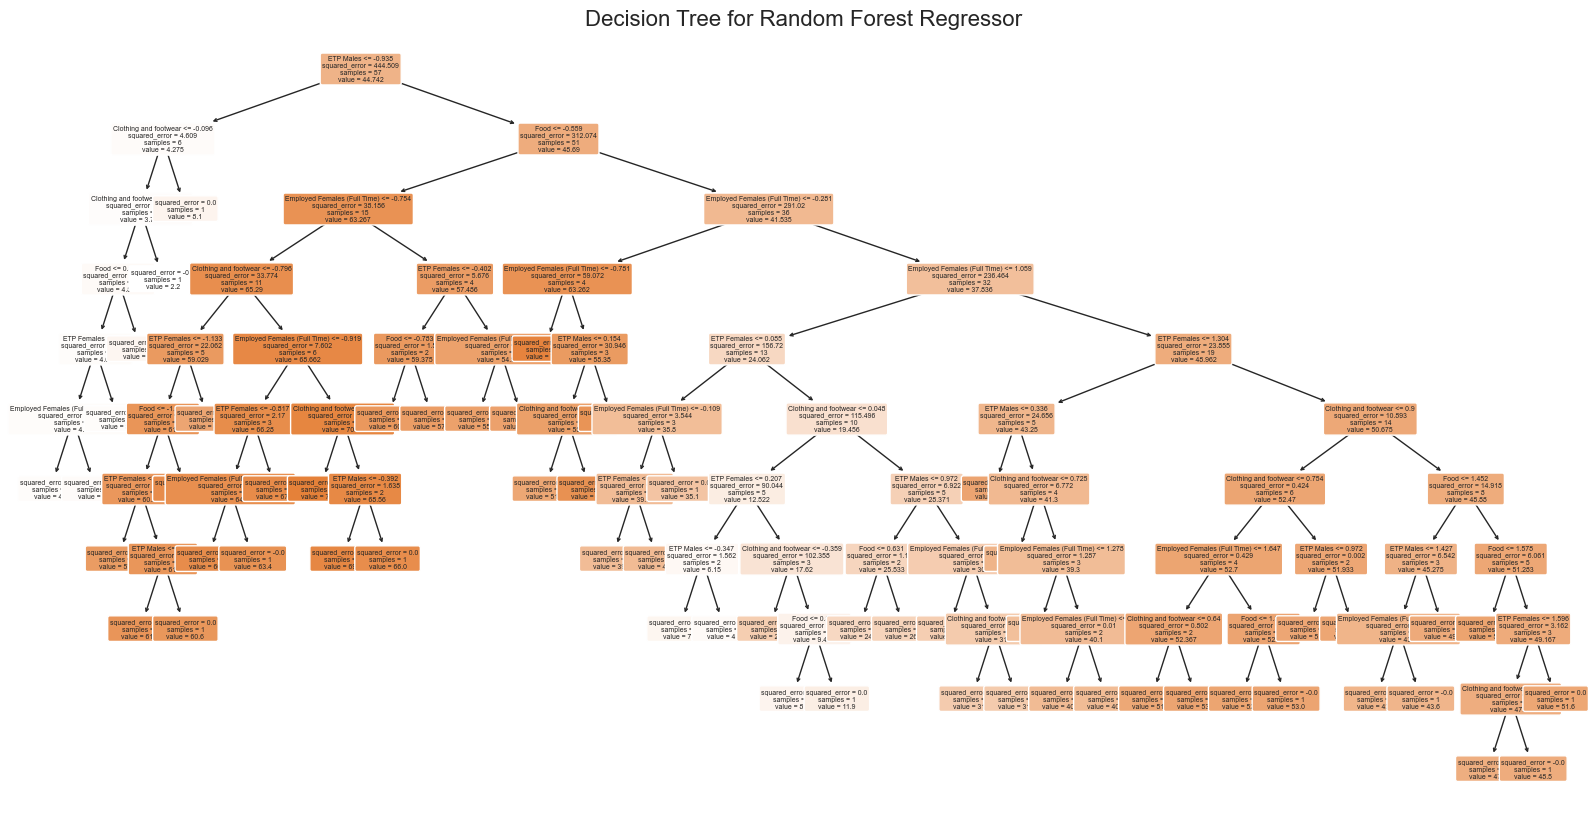

In [19]:
# Visualize the first tree in the model with larger labels
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0],
          filled=True,
          feature_names=X_train.columns,
          class_names=['Target'],
          rounded=True,
          fontsize=5)  # Adjust fontsize as needed
plt.title("Decision Tree for Random Forest Regressor", fontsize=16)

# Save the plot to the 'plots' directory with high resolution (300 dpi)
plt.savefig(os.path.join('./plots', 'Fig5_Decision Tree for Random Forest Regressor.png'), dpi=300)  # Save the plot

plt.show()



<h2>Part 2.2 : Modelling with SVM</h2>

In [20]:
#train SVM model with hyper tuning

# Create an SVR model
svm_model = SVR()

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [50, 100, 150,200],
    'epsilon': [0.01, 0.1, 0.2, 1.0],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # This is only used when kernel='poly'
}

# Perform GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv= 5 , scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_svm = grid_search.best_estimator_

# Make predictions
svm_predictions = best_svm.predict(X_test_scaled)

# Calculate R² score
from sklearn.metrics import r2_score
svm_r2 = r2_score(y_test, svm_predictions)

# Print best parameters and R2
print("Best parameters for SVM:", grid_search.best_params_)
print(f"SVM R² Score: {svm_r2}")



Best parameters for SVM: {'C': 100, 'degree': 2, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
SVM R² Score: 0.6630911256666858


<h2>Part 2.3 : Modelling with Gradient Boosting</h2>

In [21]:
# train Gradient Boosting Regressor with hyper tuning

# Define the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 500],  # Number of estimators
    'learning_rate': uniform(0.01, 0.2),   # Learning rate
    'max_depth': [3, 5, 7, 10],            # Maximum depth of trees
    'min_samples_split': [2, 5, 10, 20],   # Minimum samples required to split a node
    'subsample': uniform(0.8, 0.2),        # Fraction of samples used for training each tree
    'min_samples_leaf': [1, 2, 5]         # Minimum samples required to be at a leaf node

}

# Define the Stratified K-Fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist,
                                   n_iter=100, cv=cv, scoring='r2', random_state=42)

# Fit the model with the random search
random_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and best R² score from RandomizedSearchCV
print(f'Best Hyperparameters for gbr: {random_search.best_params_}')
#print(f'Best R² Score from RandomizedSearchCV: {random_search.best_score_:.4f}')

# Get the best estimator from the grid search
best_gbr = random_search.best_estimator_

# Predict on the test data with the best model
y_pred = best_gbr.predict(X_test_scaled)

# Evaluate the model using R² score
r2 = r2_score(y_test, y_pred)
print(f'R² Score on Test Data: {r2:.4f}')


Best Hyperparameters for gbr: {'learning_rate': 0.09687887310208573, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.93378481193262}
R² Score on Test Data: 0.8193


In [22]:
# Save the trained model (best_gbr is your trained model)
joblib.dump(best_gbr, 'gbr_model.pkl')
joblib.dump(best_rf, 'rf_model.pkl')


['rf_model.pkl']